# Predicting Winner of a LOL Match at Different Time Points

### CEE 690-03 Final Project  Yunxuan Li, Jie Chen

In [23]:
import pandas as pd
import numpy as np
import scipy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

First, we import data that has been collected and preprocessed in RStudio.

In [13]:
data_silver=pd.read_csv("Data_silver.csv")
data_gold=pd.read_csv("Data_gold.csv")
data_plat=pd.read_csv("Data_Plat.csv")
data_diamond=pd.read_csv("Data_diamond.csv")

We then merge them into one dataframe.

In [67]:
data=data_silver.append([data_gold,data_plat,data_diamond])
X=np.array(data.values[:,7:],'double')
Y=np.array(data.values[:,1],'double')

In [284]:
data

,Unnamed: 0,Result,MasteryDif_Top,MasteryDif_Jg,MasteryDif_Mid,MasteryDif_ADC,MasteryDif_Sup,Gold10Dif_Top,Gold10Dif_Jg,Gold10Dif_Mid,...,CS_A,CS_S,TowerDif,Drags,Baron,Rank_Top,Rank_Jg,Rank_Mid,Rank_ADC,Rank_Sup
0,1,100,0,0,0,0,0,98.3,-33.4,-16.5,...,25.0,116.0,8,1,0,-350,-600,950,650.0,-650.0
1,2,100,0,0,0,0,0,16.0,-26.7,-66.8,...,17.0,-6.0,5,2,1,-350,-650,0,0.0,-650.0
2,3,200,0,0,0,0,0,-4.7,85.4,77.6,...,5.0,31.0,-4,-2,-1,-350,0,-300,-650.0,650.0
3,4,200,0,0,0,0,0,115.4,-59.7,-31.1,...,28.0,-3.0,-4,0,-1,300,0,650,0.0,-300.0
4,5,200,0,0,0,0,0,0.7,43.7,56.3,...,-8.0,4.0,-4,-4,0,-950,-300,300,-600.0,-300.0
5,6,100,0,0,0,0,0,38.7,0.8,86.4,...,0.0,0.0,8,2,1,-350,350,-650,0.0,0.0
6,8,200,0,0,0,0,0,-22.9,-104.1,-16.1,...,-68.0,-7.0,-7,-2,-1,650,0,0,0.0,300.0
7,10,100,0,0,0,0,0,98.6,56.8,115.4,...,-49.0,-32.0,4,3,2,-600,0,0,0.0,0.0
8,11,200,0,0,0,0,0,43.2,-8.5,-86.7,...,-5.0,-12.0,-5,-4,-1,0,-300,-650,-350.0,650.0
9,13,100,0,0,0,0,0,91.7,3.7,39.6,...,-27.0,30.0,8,0,2,650,0,-300,650.0,-650.0


In [15]:
where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0

Y[Y==100]=1
Y[Y==200]=0

In [187]:
np.any(np.isnan(X))

False

Divide the dataset into two part: test and train. The test part will be used to do the final performance evaluation, while cross validation process will take place in the train dataset.

In [17]:
XX, X_TEST, YY, Y_TEST = train_test_split(X, Y, test_size=0.1, random_state=42)

We first use KNN. 

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest

In [94]:
XX.shape

(3140, 63)

# 1. Using K-Nearest Neighbors

## a. Prematch information

In [128]:
XX_Prematch=XX[:,58:63]
X_TEST_Prematch=X_TEST[:,58:63]

In [188]:
from sklearn.preprocessing import StandardScaler
X_scaler=StandardScaler()
X_scaler.fit(XX_Prematch)
XX_pre_scaled=X_scaler.transform(XX_Prematch)   
X_TEST_pre_scaled=X_scaler.transform(X_TEST_Prematch)

In [133]:
skf = StratifiedKFold(n_splits=5)
X=XX_pre_scaled
y=YY
splits_training_auc =[]
splits_test_auc =[]

features_settings=range(1,6)
neighbors_settings=range(1,50)

train_auc_3d_pre=np.zeros((5,5,50))
test_auc_3d_pre=np.zeros((5,5,50))
i=0 #use i,j,k for indexting so that I can store auc value in corresponding position for each iteration 
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    j=0
    for features in features_settings:
        
        feature_selector=SelectKBest(k=features)
        feature_selector.fit(X_train,y_train)
        X_train_rescaled_subset=feature_selector.transform(X_train)
        X_test_rescaled_subset=feature_selector.transform(X_test)
        k=0
        for n_neighbors in neighbors_settings:        
            # fit classifier
            clf = KNeighborsClassifier(n_neighbors=n_neighbors)
            clf.fit(X_train_rescaled_subset, y_train)
        
        
            # training
            dec_stat=clf.predict_proba(X_train_rescaled_subset)[:,0]
            fpr, tpr, _ = roc_curve(y_train,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            train_auc_3d_pre[i,j,k]=roc_auc
            #training_auc.append(roc_auc)
            
            # testing
            dec_stat=clf.predict_proba(X_test_rescaled_subset)[:,0]
            fpr, tpr, _ = roc_curve(y_test,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            test_auc_3d_pre[i,j,k]=roc_auc
            k=k+1
        j=j+1
    i=i+1

In [138]:
#determine number of features to keep
step1_train=np.mean(train_auc_3d_pre,axis=0)#first average across cross-validation
step2_train=np.mean(step1_train,axis=1)#then average across different number of neighbors
#print(step2_train)

step1_test=np.mean(test_auc_3d_pre,axis=0)#first average across cross-validation
step2_test=np.mean(step1_test,axis=1)#then average across different number of neighbors
#print(step2_test)

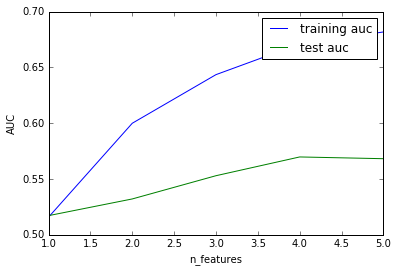

In [139]:
fig=plt.figure()
plt.plot(features_settings, step2_train, label="training auc")
plt.plot(features_settings, step2_test, label="test auc")
plt.ylabel("AUC")
plt.xlabel("n_features")
plt.legend()

In [140]:
np.argmax(step2_test)

3

4 features.

In [136]:
#determine number of neighbors in KNN
step1_train=np.mean(train_auc_3d_10,axis=0)#first average across cross-validation
step2_train=np.mean(step1_train,axis=0)#then average across different number of neighbors
print(step2_train)

step1_test=np.mean(test_auc_3d_10,axis=0)#first average across cross-validation
step2_test=np.mean(step1_test,axis=0)#then average across different number of neighbors
print(step2_test)

[ 0.99504545  0.92964689  0.89509036  0.87414503  0.85946498  0.84892651
  0.84101979  0.83463352  0.82945204  0.82493003  0.82143704  0.81804685
  0.81497807  0.81232418  0.81008768  0.80798335  0.80587635  0.80403298
  0.80229996  0.80075264  0.79943621  0.79804426  0.79675373  0.79559468
  0.79431327  0.79321596  0.79213573  0.79121468  0.7902975   0.78938365
  0.78850545  0.78762844  0.78675663  0.78601894  0.7852488   0.78437105
  0.78355594  0.78281127  0.78213334  0.78139264  0.7806022   0.77989896
  0.77930937  0.77861903  0.77793584  0.77729148  0.77663735  0.77600665
  0.7754527   0.        ]
[ 0.62255791  0.66833121  0.69179132  0.70533987  0.7161676   0.72314548
  0.72978158  0.73352204  0.73689304  0.73919082  0.7415515   0.74399462
  0.7458047   0.74687719  0.74804514  0.74881145  0.74979788  0.7502522
  0.75046723  0.75121525  0.75161617  0.75212241  0.75246952  0.75277309
  0.75296521  0.75331344  0.75331852  0.75370632  0.75360906  0.75360966
  0.7538331   0.75397518  

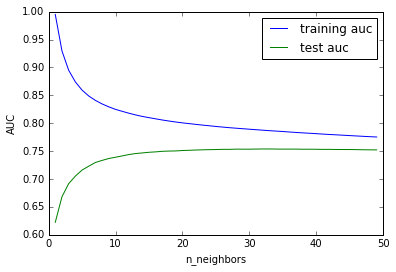

In [137]:
fig=plt.figure()
plt.plot(neighbors_settings, step2_train[0:49], label="training auc")
plt.plot(neighbors_settings, step2_test[0:49], label="test auc")
plt.ylabel("AUC")
plt.xlabel("n_neighbors")
plt.legend()

The more neighbors, the better.

In [189]:
feature_selector=SelectKBest(k=4)
feature_selector.fit(XX_pre_scaled,YY)
X_selected=feature_selector.transform(XX_pre_scaled)#all data
clf = KNeighborsClassifier(n_neighbors=50)
clf.fit(X_selected, YY)

X_test=feature_selector.transform(X_TEST_pre_scaled)

dec_stat=clf.predict_proba(X_test)[:,0]
fpr, tpr, _ = roc_curve(Y_TEST,dec_stat,pos_label=0)
roc_auc = auc(fpr, tpr)
roc_auc

0.54945616348055382

## b. 10-minute Information

In [74]:
XX_10=XX[:,list(range(0,20))+list(range(58,63))]
X_TEST_10=X_TEST[:,list(range(0,20))+list(range(58,63))]



In [76]:
from sklearn.preprocessing import StandardScaler
X_scaler=StandardScaler()
X_scaler.fit(XX_10)
XX_10_scaled=X_scaler.transform(XX_10)   
X_TEST_10_scaled=X_scaler.transform(X_TEST_10)

In [116]:
XX_10_scaled.shape

(3140, 25)

In [117]:
skf = StratifiedKFold(n_splits=5)
X=XX_10_scaled
y=YY
splits_training_auc =[]
splits_test_auc =[]

features_settings=range(1,25)
neighbors_settings=range(1,50)

train_auc_3d_10=np.zeros((5,24,50))
test_auc_3d_10=np.zeros((5,24,50))
i=0 #use i,j,k for indexting so that I can store auc value in corresponding position for each iteration 
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    j=0
    for features in features_settings:
        
        feature_selector=SelectKBest(k=features)
        feature_selector.fit(X_train,y_train)
        X_train_rescaled_subset=feature_selector.transform(X_train)
        X_test_rescaled_subset=feature_selector.transform(X_test)
        k=0
        for n_neighbors in neighbors_settings:        
            # fit classifier
            clf = KNeighborsClassifier(n_neighbors=n_neighbors)
            clf.fit(X_train_rescaled_subset, y_train)
        
        
            # training
            dec_stat=clf.predict_proba(X_train_rescaled_subset)[:,0]
            fpr, tpr, _ = roc_curve(y_train,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            train_auc_3d_10[i,j,k]=roc_auc
            #training_auc.append(roc_auc)
            
            # testing
            dec_stat=clf.predict_proba(X_test_rescaled_subset)[:,0]
            fpr, tpr, _ = roc_curve(y_test,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            test_auc_3d_10[i,j,k]=roc_auc
            k=k+1
        j=j+1
    i=i+1

In [118]:
#determine number of features to keep
step1_train=np.mean(train_auc_3d_10,axis=0)#first average across cross-validation
step2_train=np.mean(step1_train,axis=1)#then average across different number of neighbors
#print(step2_train)

step1_test=np.mean(test_auc_3d_10,axis=0)#first average across cross-validation
step2_test=np.mean(step1_test,axis=1)#then average across different number of neighbors
#print(step2_test)

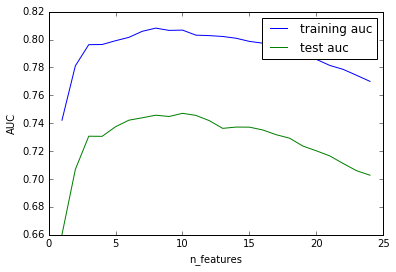

In [119]:
fig=plt.figure()
plt.plot(features_settings, step2_train, label="training auc")
plt.plot(features_settings, step2_test, label="test auc")
plt.ylabel("AUC")
plt.xlabel("n_features")
plt.legend()

In [120]:
np.argmax(step2_test)

9

10 features.

In [123]:
#determine number of neighbors in KNN
step1_train=np.mean(train_auc_3d_10,axis=0)#first average across cross-validation
step2_train=np.mean(step1_train,axis=0)#then average across different number of neighbors
print(step2_train)

step1_test=np.mean(test_auc_3d_10,axis=0)#first average across cross-validation
step2_test=np.mean(step1_test,axis=0)#then average across different number of neighbors
print(step2_test)

[ 0.99504545  0.92964689  0.89509036  0.87414503  0.85946498  0.84892651
  0.84101979  0.83463352  0.82945204  0.82493003  0.82143704  0.81804685
  0.81497807  0.81232418  0.81008768  0.80798335  0.80587635  0.80403298
  0.80229996  0.80075264  0.79943621  0.79804426  0.79675373  0.79559468
  0.79431327  0.79321596  0.79213573  0.79121468  0.7902975   0.78938365
  0.78850545  0.78762844  0.78675663  0.78601894  0.7852488   0.78437105
  0.78355594  0.78281127  0.78213334  0.78139264  0.7806022   0.77989896
  0.77930937  0.77861903  0.77793584  0.77729148  0.77663735  0.77600665
  0.7754527   0.        ]
[ 0.62255791  0.66833121  0.69179132  0.70533987  0.7161676   0.72314548
  0.72978158  0.73352204  0.73689304  0.73919082  0.7415515   0.74399462
  0.7458047   0.74687719  0.74804514  0.74881145  0.74979788  0.7502522
  0.75046723  0.75121525  0.75161617  0.75212241  0.75246952  0.75277309
  0.75296521  0.75331344  0.75331852  0.75370632  0.75360906  0.75360966
  0.7538331   0.75397518  

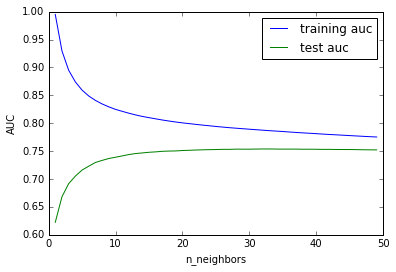

In [125]:
fig=plt.figure()
plt.plot(neighbors_settings, step2_train[0:49], label="training auc")
plt.plot(neighbors_settings, step2_test[0:49], label="test auc")
plt.ylabel("AUC")
plt.xlabel("n_neighbors")
plt.legend()

In [211]:
feature_selector=SelectKBest(k=10)
feature_selector.fit(XX_10_scaled,YY)
X_selected=feature_selector.transform(XX_10_scaled)#all data
clf = KNeighborsClassifier(n_neighbors=50)
clf.fit(X_selected, YY)

X_test=feature_selector.transform(X_TEST_10_scaled)

dec_stat=clf.predict_proba(X_test)[:,0]
fpr, tpr, _ = roc_curve(Y_TEST,dec_stat,pos_label=0)
roc_auc = auc(fpr, tpr)
roc_auc

0.79499011206328274

In [212]:
idxs_selected = feature_selector.get_support(indices=True)

In [213]:
idxs_selected

array([ 0,  1,  2,  3,  4,  8,  9, 12, 13, 14])

In [371]:
len(XX)

3140

In [339]:
scale_accuracy

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [374]:
import random
#ind=random.sample(range(0,len(XX)), 300*(i+1))
KNN_10_accuracy=np.zeros((10,20))
XX_10=XX[:,list(range(0,20))+list(range(58,63))]
X_TEST_10=X_TEST[:,list(range(0,20))+list(range(58,63))]

from sklearn.preprocessing import StandardScaler
X_scaler=StandardScaler()
X_scaler.fit(XX_10)
XX_10_scaled=X_scaler.transform(XX_10)   
X_TEST_10_scaled=X_scaler.transform(X_TEST_10)

In [375]:
for j in range(10):
    for i in range(20):
        ind=random.sample(range(0,len(XX)), 150*(i+1))

        XX_10_ind=XX_10_scaled[ind]
        YY_ind=YY[ind]

        feature_selector=SelectKBest(k=10)
        feature_selector.fit(XX_10_ind,YY_ind)
        X_selected=feature_selector.transform(XX_10_ind)#all data
        clf = KNeighborsClassifier(n_neighbors=50)
        clf.fit(X_selected, YY_ind)

        X_test=feature_selector.transform(X_TEST_10_scaled)

        dec_stat=clf.predict_proba(X_test)[:,0]
        fpr, tpr, _ = roc_curve(Y_TEST,dec_stat,pos_label=0)
        roc_auc = auc(fpr, tpr)
        KNN_10_accuracy[j,i]=roc_auc
    

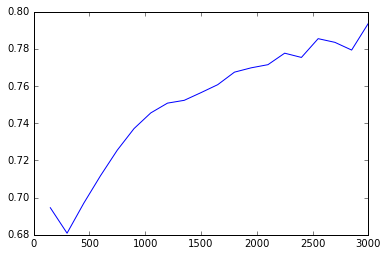

In [376]:
plt.figure()
plt.plot(150*(np.arange(20)+1),np.mean(KNN_10_accuracy,axis=0))

In [340]:
len(XX)

3140

features_dataframe_new = features_dataframe[idxs_selected]

## c. Full Information

In [196]:
from sklearn.preprocessing import StandardScaler
X_scaler=StandardScaler()
X_scaler.fit(XX)
XX_scaled=X_scaler.transform(XX)   
X_TEST_scaled=X_scaler.transform(X_TEST)

In [20]:
skf = StratifiedKFold(n_splits=5)
X=XX_scaled
y=YY
splits_training_auc =[]
splits_test_auc =[]

features_settings=range(1,40)
neighbors_settings=range(1,40)

train_auc_3d=np.zeros((5,40,40))
test_auc_3d=np.zeros((5,40,40))
i=0 #use i,j,k for indexting so that I can store auc value in corresponding position for each iteration 
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    j=0
    for features in features_settings:
        
        feature_selector=SelectKBest(k=features)
        feature_selector.fit(X_train,y_train)
        X_train_rescaled_subset=feature_selector.transform(X_train)
        X_test_rescaled_subset=feature_selector.transform(X_test)
        k=0
        for n_neighbors in neighbors_settings:        
            # fit classifier
            clf = KNeighborsClassifier(n_neighbors=n_neighbors)
            clf.fit(X_train_rescaled_subset, y_train)
        
        
            # training
            dec_stat=clf.predict_proba(X_train_rescaled_subset)[:,0]
            fpr, tpr, _ = roc_curve(y_train,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            train_auc_3d[i,j,k]=roc_auc
            #training_auc.append(roc_auc)
            
            # testing
            dec_stat=clf.predict_proba(X_test_rescaled_subset)[:,0]
            fpr, tpr, _ = roc_curve(y_test,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            test_auc_3d[i,j,k]=roc_auc
            k=k+1
        j=j+1
    i=i+1

In [103]:
#determine number of features to keep
step1_train=np.mean(train_auc_3d,axis=0)#first average across cross-validation
step2_train=np.mean(step1_train,axis=1)#then average across different number of neighbors
#print(step2_train)

step1_test=np.mean(test_auc_3d,axis=0)#first average across cross-validation
step2_test=np.mean(step1_test,axis=1)#then average across different number of neighbors
#print(step2_test)

In [104]:
step2_test

array([ 0.96213972,  0.96938871,  0.97023688,  0.96973412,  0.97127509,
        0.97043317,  0.97039846,  0.96980714,  0.9700332 ,  0.97026824,
        0.96988293,  0.96978237,  0.96951616,  0.96938576,  0.96799481,
        0.96782408,  0.96661947,  0.9660601 ,  0.96633439,  0.96625655,
        0.96575802,  0.96550922,  0.96518647,  0.96416019,  0.96489714,
        0.96366128,  0.96335381,  0.96370484,  0.96255159,  0.96179756,
        0.96193427,  0.96223317,  0.9620046 ,  0.95992734,  0.95860351,
        0.95895149,  0.95967243,  0.95923072,  0.95888267,  0.        ])

In [105]:
step2_train

array([ 0.96267676,  0.97359585,  0.97379764,  0.97380445,  0.97388921,
        0.97372249,  0.97354471,  0.97334324,  0.97334908,  0.97340803,
        0.9733935 ,  0.97334771,  0.97327096,  0.97312756,  0.97295954,
        0.97289131,  0.97266479,  0.97255595,  0.97249801,  0.97238465,
        0.97228523,  0.97217575,  0.97211476,  0.97188288,  0.97170993,
        0.97161028,  0.97130226,  0.97121696,  0.97101182,  0.97083445,
        0.97064217,  0.97052321,  0.9703703 ,  0.97024473,  0.97018899,
        0.97004289,  0.96985264,  0.96978929,  0.96965373,  0.        ])

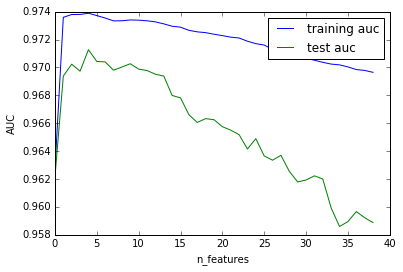

In [106]:
fig=plt.figure()
plt.plot(range(0,39), step2_train[0:39], label="training auc")
plt.plot(range(0,39), step2_test[0:39], label="test auc")
plt.ylabel("AUC")
plt.xlabel("n_features")
plt.legend()

In [41]:
np.argmax(step2_test)

4

5 features to keep.

In [99]:
#determine number of neighbors in KNN
step1_train=np.mean(train_auc_3d,axis=0)#first average across cross-validation
step2_train=np.mean(step1_train,axis=0)#then average across different number of neighbors
print(step2_train)

step1_test=np.mean(test_auc_3d,axis=0)#first average across cross-validation
step2_test=np.mean(step1_test,axis=0)#then average across different number of neighbors
print(step2_test)

max(step2_test)

[ 0.97388347  0.97392604  0.97372761  0.97347701  0.97329634  0.97311843
  0.97295288  0.97283332  0.97268672  0.97256253  0.9724419   0.97235265
  0.97224235  0.97217338  0.97207287  0.97198309  0.97188963  0.97180266
  0.97172231  0.9716473   0.97157193  0.97149445  0.97142834  0.97136106
  0.97129011  0.97122057  0.97115555  0.97108795  0.97104826  0.97098472
  0.97092322  0.97086164  0.97080211  0.97074862  0.97069452  0.97063636
  0.97058016  0.97052202  0.97047361  0.        ]
[ 0.94332612  0.95705485  0.96111871  0.96312457  0.96444394  0.96530911
  0.96569359  0.96599249  0.96627086  0.96641008  0.96656243  0.96670985
  0.96671967  0.96686733  0.96691261  0.9669313   0.96693963  0.96698632
  0.96698455  0.96697993  0.96698163  0.96695271  0.96695099  0.96693517
  0.96689707  0.96687146  0.96684215  0.96680633  0.9667999   0.96675728
  0.96672693  0.96669629  0.9666558   0.96661909  0.96658225  0.96653907
  0.96651605  0.96648174  0.96644187  0.        ]


0.96698631893094844

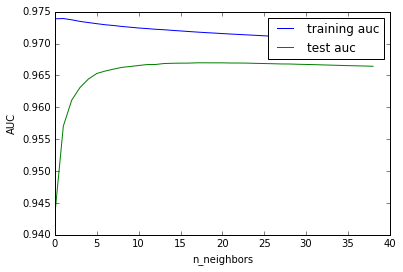

In [102]:
fig=plt.figure()
plt.plot(range(0,39), step2_train[0:39], label="training auc")
plt.plot(range(0,39), step2_test[0:39], label="test auc")
plt.ylabel("AUC")
plt.xlabel("n_neighbors")
plt.legend()

In [45]:
np.argmax(step2_test)

17

18 neighbors to keep.

In [197]:
feature_selector=SelectKBest(k=5)
feature_selector.fit(XX_scaled,YY)
X_selected=feature_selector.transform(XX_scaled)#all data
clf = KNeighborsClassifier(n_neighbors=18)
clf.fit(X_selected, YY)

X_test=feature_selector.transform(X_TEST_scaled)

dec_stat=clf.predict_proba(X_test)[:,0]
fpr, tpr, _ = roc_curve(Y_TEST,dec_stat,pos_label=0)
roc_auc = auc(fpr, tpr)
roc_auc

0.99497363216875412

In [380]:
import random
X_scaler=StandardScaler()
X_scaler.fit(XX)
XX_scaled=X_scaler.transform(XX)   
X_TEST_scaled=X_scaler.transform(X_TEST)

KNN_full_accuracy=np.zeros((10,20))

In [381]:
for j in range(10):
    for i in range(20):
        ind=random.sample(range(0,len(XX)), 150*(i+1))

        XX_ind=XX_scaled[ind]
        YY_ind=YY[ind]

        feature_selector=SelectKBest(k=10)
        feature_selector.fit(XX_ind,YY_ind)
        X_selected=feature_selector.transform(XX_ind)#all data
        clf = KNeighborsClassifier(n_neighbors=50)
        clf.fit(X_selected, YY_ind)

        X_test=feature_selector.transform(X_TEST_scaled)

        dec_stat=clf.predict_proba(X_test)[:,0]
        fpr, tpr, _ = roc_curve(Y_TEST,dec_stat,pos_label=0)
        roc_auc = auc(fpr, tpr)
        KNN_full_accuracy[j,i]=roc_auc
    

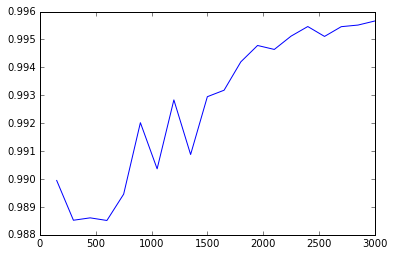

In [382]:
plt.figure()
plt.plot(150*(np.arange(20)+1),np.mean(KNN_full_accuracy,axis=0))

# 2. Using Random Forest

## c. Full Information

In [259]:
from sklearn.ensemble import RandomForestClassifier

In [325]:
X_scaler=StandardScaler()
X_scaler.fit(XX)
XX_scaled=X_scaler.transform(XX)   
X_TEST_scaled=X_scaler.transform(X_TEST)

In [261]:
skf = StratifiedKFold(n_splits=5)
X=XX_scaled
y=YY
splits_training_auc =[]
splits_test_auc =[]

trees_settings=[50,75,100,125,150,175,200,225,250]
depth_settings=range(2,7)
train_auc_RF_F=np.zeros((5,9,5))
test_auc_RF_F=np.zeros((5,9,5))
i=0 #use i,j,k for indexting so that I can store auc value in corresponding position for each iteration 
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    j=0
    for n_trees in trees_settings:   
        k=0
        for n_depth in depth_settings:
        
            # fit classifier
            clf = RandomForestClassifier(n_estimators=n_trees, max_features="auto",max_depth=n_depth,random_state=42)
            clf.fit(X_train, y_train)


            # training
            dec_stat=clf.predict_proba(X_train)[:,0]
            fpr, tpr, _ = roc_curve(y_train,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            train_auc_RF_F[i,j,k]=roc_auc
            #training_auc.append(roc_auc)

            # testing
            dec_stat=clf.predict_proba(X_test)[:,0]
            fpr, tpr, _ = roc_curve(y_test,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            test_auc_RF_F[i,j,k]=roc_auc
            k=k+1
        
        j=j+1
    i=i+1

In [263]:
#determine number of features to keep
step1_train=np.mean(train_auc_RF_F,axis=0)#first average across cross-validation
step2_train=np.mean(step1_train,axis=0)#now is depth
print(step2_train)

step1_test=np.mean(test_auc_RF_F,axis=0)#first average across cross-validation
step2_test=np.mean(step1_test,axis=0)
print(step2_test)

[ 0.99838826  0.99912049  0.99960748  0.99990807  0.99998628]
[ 0.99823443  0.99870049  0.99886618  0.99901454  0.99910821]


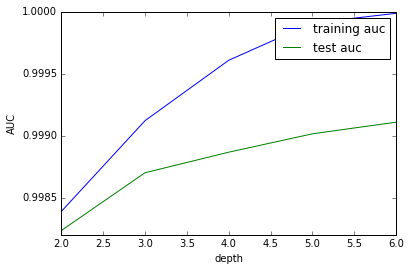

In [264]:
fig=plt.figure()
plt.plot(depth_settings, step2_train, label="training auc")
plt.plot(depth_settings, step2_test, label="test auc")
plt.ylabel("AUC")
plt.xlabel("depth")
plt.legend()

6

In [267]:
#determine number of features to keep
step1_train=np.mean(train_auc_RF_F,axis=0)#first average across cross-validation
step2_train=np.mean(step1_train,axis=1)#now is n_trees
print(step2_train)

step1_test=np.mean(test_auc_RF_F,axis=0)#first average across cross-validation
step2_test=np.mean(step1_test,axis=1)
print(step2_test)

[ 0.99937374  0.99932361  0.999328    0.99939253  0.9994704   0.99945291
  0.99944881  0.99940558  0.99942348]
[ 0.99869261  0.99869712  0.9987283   0.99879147  0.9988649   0.99884849
  0.99885177  0.99878901  0.99879927]


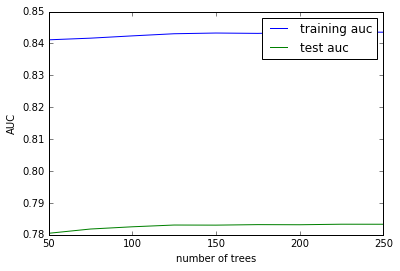

In [266]:
fig=plt.figure()
plt.plot(trees_settings, step2_train, label="training auc")
plt.plot(trees_settings, step2_test, label="test auc")
plt.ylabel("AUC")
plt.xlabel("number of trees")
plt.legend()

In [268]:
np.argmax(step2_test)

4

125

In [326]:
clf = RandomForestClassifier(n_estimators=125, max_features="auto",max_depth=6,random_state=42)
clf.fit(XX_scaled, YY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=125, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [269]:
dec_stat=clf.predict_proba(X_TEST_scaled)[:,0]
fpr, tpr, _ = roc_curve(Y_TEST,dec_stat,pos_label=0)
roc_auc = auc(fpr, tpr)
roc_auc

0.99887936717205017

In [323]:
cols=data.columns.values[7:]

In [328]:
clf.feature_importances_

array([ 0.00159512,  0.00216917,  0.00150185,  0.00218206,  0.00115783,
        0.00084386,  0.00069238,  0.00079496,  0.001218  ,  0.00056269,
        0.00116594,  0.00101161,  0.00110477,  0.00157176,  0.00090229,
        0.00070018,  0.00077893,  0.00100883,  0.00069334,  0.00071305,
        0.00413135,  0.01591749,  0.00300809,  0.01893544,  0.00107271,
        0.00614813,  0.00952926,  0.01349708,  0.02525137,  0.00102255,
        0.03545692,  0.06842159,  0.07331905,  0.07255473,  0.04629088,
        0.01172529,  0.01692293,  0.02929847,  0.02733332,  0.09233363,
        0.00050202,  0.00046664,  0.00054207,  0.00043644,  0.00079156,
        0.00269645,  0.00171495,  0.00409907,  0.00892681,  0.00588193,
        0.00185334,  0.00106477,  0.0031903 ,  0.00182463,  0.00107067,
        0.26710353,  0.04510116,  0.05572807,  0.00048138,  0.00048746,
        0.00057409,  0.00058559,  0.00033817])

In [329]:
indices

array([62, 43, 41, 58, 59, 40, 42,  9, 60, 61,  6, 18, 15, 19, 16, 44,  7,
        5, 14, 17, 11, 29, 51, 54, 24, 12,  4, 10,  8,  2, 13,  0, 46, 53,
       50,  1,  3, 45, 22, 52, 47, 20, 49, 25, 48, 26, 35, 27, 21, 36, 23,
       28, 38, 37, 30, 56, 34, 57, 31, 33, 32, 39, 55])

In [327]:
importance = clf.feature_importances_

indices = np.argsort(importance)

cols[indices]

array(['Rank_Sup', 'Vision_A', 'Vision_J', 'Rank_Top', 'Rank_Jg',
       'Vision_T', 'Vision_M', 'CS10Dif_Sup', 'Rank_Mid', 'Rank_ADC',
       'CS10Dif_Jg', 'DmgTaken10_ADC', 'DmgTaken10_Top', 'DmgTaken10_Sup',
       'DmgTaken10_Jg', 'Vision_S', 'CS10Dif_Mid', 'CS10Dif_Top',
       'Exp10Dif_Sup', 'DmgTaken10_Mid', 'Exp10Dif_Jg', 'Kills_S', 'CS_J',
       'CS_S', 'Dmg_Sup', 'Exp10Dif_Mid', 'Gold10Dif_Sup', 'Exp10Dif_Top',
       'CS10Dif_ADC', 'Gold10Dif_Mid', 'Exp10Dif_ADC', 'Gold10Dif_Top',
       'DmgTaken_J', 'CS_A', 'CS_T', 'Gold10Dif_Jg', 'Gold10Dif_ADC',
       'DmgTaken_T', 'Dmg_Mid', 'CS_M', 'DmgTaken_M', 'Dmg_Top',
       'DmgTaken_S', 'Kills_T', 'DmgTaken_A', 'Kills_J', 'Assists_T',
       'Kills_M', 'Dmg_Jg', 'Assists_J', 'Dmg_ADC', 'Kills_A', 'Assists_A',
       'Assists_M', 'Deaths_T', 'Drags', 'Deaths_S', 'Baron', 'Deaths_J',
       'Deaths_A', 'Deaths_M', 'Assists_S', 'TowerDif'], dtype=object)

## b. 10-minute 

In [219]:
XX_10=XX[:,list(range(0,20))+list(range(58,63))]
X_TEST_10=X_TEST[:,list(range(0,20))+list(range(58,63))]

In [331]:
X_scaler=StandardScaler()
X_scaler.fit(XX_10)
XX_scaled=X_scaler.transform(XX_10)   
X_TEST_scaled=X_scaler.transform(X_TEST_10)

In [176]:
XX_10.shape

(3140, 25)

In [235]:
skf = StratifiedKFold(n_splits=5)
X=XX_scaled
y=YY
splits_training_auc =[]
splits_test_auc =[]

trees_settings=[50,75,100,125,150,175,200,225,250]
depth_settings=range(2,7)
train_auc_RF=np.zeros((5,9,5))
test_auc_RF=np.zeros((5,9,5))
i=0 #use i,j,k for indexting so that I can store auc value in corresponding position for each iteration 
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    j=0
    for n_trees in trees_settings:   
        k=0
        for n_depth in depth_settings:
        
            # fit classifier
            clf = RandomForestClassifier(n_estimators=n_trees, max_features="auto",max_depth=n_depth,random_state=42)
            clf.fit(X_train, y_train)


            # training
            dec_stat=clf.predict_proba(X_train)[:,0]
            fpr, tpr, _ = roc_curve(y_train,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            train_auc_RF[i,j,k]=roc_auc
            #training_auc.append(roc_auc)

            # testing
            dec_stat=clf.predict_proba(X_test)[:,0]
            fpr, tpr, _ = roc_curve(y_test,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            test_auc_RF[i,j,k]=roc_auc
            k=k+1
        
        j=j+1
    i=i+1

In [240]:
#determine number of features to keep
step1_train=np.mean(train_auc_RF,axis=0)#first average across cross-validation
step2_train=np.mean(step1_train,axis=0)#now is depth
print(step2_train)

step1_test=np.mean(test_auc_RF,axis=0)#first average across cross-validation
step2_test=np.mean(step1_test,axis=0)
print(step2_test)

[ 0.79249976  0.81170552  0.83620035  0.86815942  0.90549347]
[ 0.77333684  0.77977365  0.78437309  0.78662113  0.78915337]


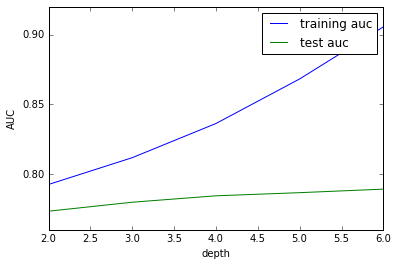

In [242]:
fig=plt.figure()
plt.plot(depth_settings, step2_train, label="training auc")
plt.plot(depth_settings, step2_test, label="test auc")
plt.ylabel("AUC")
plt.xlabel("depth")
plt.legend()

n=7.

In [243]:
#determine number of features to keep
step1_train=np.mean(train_auc_RF,axis=0)#first average across cross-validation
step2_train=np.mean(step1_train,axis=1)#now is n_trees
print(step2_train)

step1_test=np.mean(test_auc_RF,axis=0)#first average across cross-validation
step2_test=np.mean(step1_test,axis=1)
print(step2_test)

[ 0.84114969  0.84166774  0.84238648  0.84305524  0.84327846  0.84316881
  0.84346446  0.84359581  0.84353866]
[ 0.78047299  0.78181156  0.78251285  0.78306357  0.78303137  0.78319116
  0.78315424  0.78331792  0.78330889]


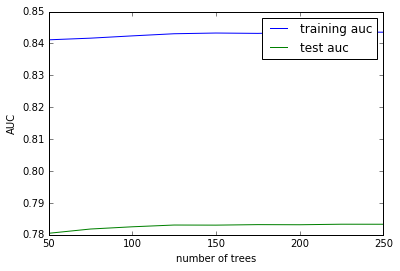

In [245]:
fig=plt.figure()
plt.plot(trees_settings, step2_train, label="training auc")
plt.plot(trees_settings, step2_test, label="test auc")
plt.ylabel("AUC")
plt.xlabel("number of trees")
plt.legend()

reaches maximum at 125. for model simplicity, just use 125.

In [332]:
clf = RandomForestClassifier(n_estimators=130, max_features="auto",max_depth=8,random_state=42)
clf.fit(XX_scaled, YY)

dec_stat=clf.predict_proba(X_TEST_scaled)[:,0]
fpr, tpr, _ = roc_curve(Y_TEST,dec_stat,pos_label=0)
roc_auc = auc(fpr, tpr)
roc_auc

0.78029004614370479

In [333]:
clf.feature_importances_

array([ 0.07714533,  0.11171752,  0.11780101,  0.10754643,  0.07333027,
        0.02310435,  0.01748072,  0.02831164,  0.02592376,  0.02668292,
        0.0303227 ,  0.03847894,  0.04580532,  0.0422453 ,  0.04616092,
        0.023708  ,  0.02469367,  0.02357288,  0.02509911,  0.02708133,
        0.01257391,  0.01262422,  0.01347757,  0.01289262,  0.01221956])

In [334]:
cols=data.columns.values[list(range(7,27))+list(range(65,70))]

In [335]:
cols

array(['Gold10Dif_Top', 'Gold10Dif_Jg', 'Gold10Dif_Mid', 'Gold10Dif_ADC',
       'Gold10Dif_Sup', 'CS10Dif_Top', 'CS10Dif_Jg', 'CS10Dif_Mid',
       'CS10Dif_ADC', 'CS10Dif_Sup', 'Exp10Dif_Top', 'Exp10Dif_Jg',
       'Exp10Dif_Mid', 'Exp10Dif_ADC', 'Exp10Dif_Sup', 'DmgTaken10_Top',
       'DmgTaken10_Jg', 'DmgTaken10_Mid', 'DmgTaken10_ADC',
       'DmgTaken10_Sup', 'Rank_Top', 'Rank_Jg', 'Rank_Mid', 'Rank_ADC',
       'Rank_Sup'], dtype=object)

In [336]:
importance = clf.feature_importances_

indices = np.argsort(importance)

cols[indices]

array(['Rank_Sup', 'Rank_Top', 'Rank_Jg', 'Rank_ADC', 'Rank_Mid',
       'CS10Dif_Jg', 'CS10Dif_Top', 'DmgTaken10_Mid', 'DmgTaken10_Top',
       'DmgTaken10_Jg', 'DmgTaken10_ADC', 'CS10Dif_ADC', 'CS10Dif_Sup',
       'DmgTaken10_Sup', 'CS10Dif_Mid', 'Exp10Dif_Top', 'Exp10Dif_Jg',
       'Exp10Dif_ADC', 'Exp10Dif_Mid', 'Exp10Dif_Sup', 'Gold10Dif_Sup',
       'Gold10Dif_Top', 'Gold10Dif_ADC', 'Gold10Dif_Jg', 'Gold10Dif_Mid'], dtype=object)

In [337]:
importance[indices]

array([ 0.01221956,  0.01257391,  0.01262422,  0.01289262,  0.01347757,
        0.01748072,  0.02310435,  0.02357288,  0.023708  ,  0.02469367,
        0.02509911,  0.02592376,  0.02668292,  0.02708133,  0.02831164,
        0.0303227 ,  0.03847894,  0.0422453 ,  0.04580532,  0.04616092,
        0.07333027,  0.07714533,  0.10754643,  0.11171752,  0.11780101])

In [360]:
import random
ind=random.sample(range(0,len(XX)), 300*(i+1))
RF_10_accuracy=np.zeros(20)

In [361]:
XX_10=XX[:,list(range(0,20))+list(range(58,63))]
X_TEST_10=X_TEST[:,list(range(0,20))+list(range(58,63))]

X_scaler=StandardScaler()
X_scaler.fit(XX_10)
XX_10_scaled=X_scaler.transform(XX_10)   
X_TEST_10_scaled=X_scaler.transform(X_TEST_10)

In [366]:
for i in range(20):
    ind=random.sample(range(0,len(XX)), 150*(i+1))
    
    XX_10_ind=XX_10_scaled[ind]
    YY_ind=YY[ind]
    
    clf = RandomForestClassifier(n_estimators=130, max_features="auto",max_depth=8,random_state=42)
    clf.fit(XX_10_ind, YY_ind)

    dec_stat=clf.predict_proba(X_TEST_scaled)[:,0]
    fpr, tpr, _ = roc_curve(Y_TEST,dec_stat,pos_label=0)
    roc_auc = auc(fpr, tpr)
    RF_10_accuracy[i]=roc_auc
    

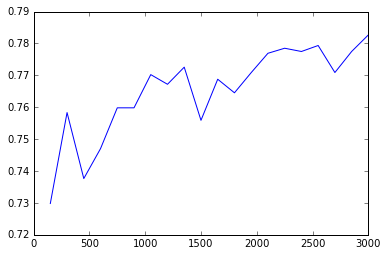

In [367]:
plt.figure()
plt.plot(150*(np.arange(20)+1),RF_10_accuracy)

## a. Prematch

In [214]:
X_scaler=StandardScaler()
X_scaler.fit(XX_Prematch)
XX_pre_scaled=X_scaler.transform(XX_Prematch)   
X_TEST_pre_scaled=X_scaler.transform(X_TEST_Prematch)

In [248]:
skf = StratifiedKFold(n_splits=5)
X=XX_pre_scaled
y=YY
splits_training_auc =[]
splits_test_auc =[]

trees_settings=[50,75,100,125,150,175,200,225,250]
depth_settings=range(2,7)
train_auc_RF_pre=np.zeros((5,9,5))
test_auc_RF_pre=np.zeros((5,9,5))
i=0 #use i,j,k for indexting so that I can store auc value in corresponding position for each iteration 
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    j=0
    for n_trees in trees_settings:   
        k=0
        for n_depth in depth_settings:
        
            # fit classifier
            clf = RandomForestClassifier(n_estimators=n_trees, max_features="auto",max_depth=n_depth,random_state=42)
            clf.fit(X_train, y_train)


            # training
            dec_stat=clf.predict_proba(X_train)[:,0]
            fpr, tpr, _ = roc_curve(y_train,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            train_auc_RF_pre[i,j,k]=roc_auc
            #training_auc.append(roc_auc)

            # testing
            dec_stat=clf.predict_proba(X_test)[:,0]
            fpr, tpr, _ = roc_curve(y_test,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            test_auc_RF_pre[i,j,k]=roc_auc
            k=k+1
        
        j=j+1
    i=i+1

In [253]:
#determine number of features to keep
step1_train=np.mean(train_auc_RF_pre,axis=0)#first average across cross-validation
step2_train=np.mean(step1_train,axis=0)#now is depth
print(step2_train)

step1_test=np.mean(test_auc_RF_pre,axis=0)#first average across cross-validation
step2_test=np.mean(step1_test,axis=0)
print(step2_test)

[ 0.6148175   0.64340765  0.68185488  0.72618957  0.77909242]
[ 0.56745453  0.5666939   0.56774032  0.57158688  0.57511871]


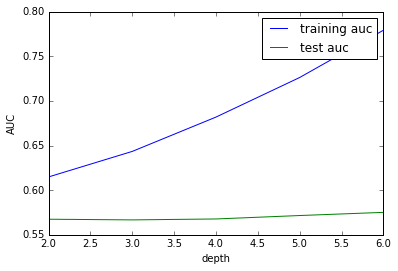

In [254]:
fig=plt.figure()
plt.plot(depth_settings, step2_train, label="training auc")
plt.plot(depth_settings, step2_test, label="test auc")
plt.ylabel("AUC")
plt.xlabel("depth")
plt.legend()

In [255]:
#determine number of features to keep
step1_train=np.mean(train_auc_RF_pre,axis=0)#first average across cross-validation
step2_train=np.mean(step1_train,axis=1)#now is depth
print(step2_train)

step1_test=np.mean(test_auc_RF_pre,axis=0)#first average across cross-validation
step2_test=np.mean(step1_test,axis=1)
print(step2_test)

[ 0.6839832   0.68641239  0.68700809  0.68836271  0.69008251  0.69068613
  0.6913543   0.69183997  0.69192236]
[ 0.57029075  0.57073277  0.57071082  0.57066077  0.56985775  0.56907402
  0.56891444  0.56857026  0.56865825]


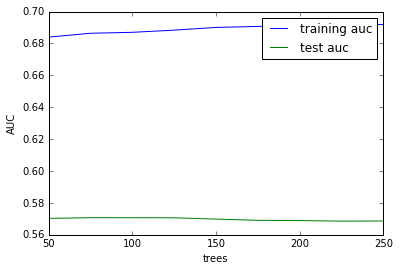

In [257]:
fig=plt.figure()
plt.plot(trees_settings, step2_train, label="training auc")
plt.plot(trees_settings, step2_test, label="test auc")
plt.ylabel("AUC")
plt.xlabel("trees")
plt.legend()

In [208]:
clf = RandomForestClassifier(n_jobs=8, random_state=42)
clf.fit(XX_pre_scaled, YY)

dec_stat=clf.predict_proba(X_TEST_pre_scaled)[:,0]
fpr, tpr, _ = roc_curve(Y_TEST,dec_stat,pos_label=0)
roc_auc = auc(fpr, tpr)
roc_auc

0.53403098220171397